In [55]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [56]:
df = pd.read_csv("ai4i2020.csv")

In [57]:
df

UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0         1     M14860    M                298.1                    308.6   
1         2     L47181    L                298.2                    308.7   
2         3     L47182    L                298.1                    308.5   
3         4     L47183    L                298.2                    308.6   
4         5     L47184    L                298.2                    308.7   
...     ...        ...  ...                  ...                      ...   
9995   9996     M24855    M                298.8                    308.4   
9996   9997     H39410    H                298.9                    308.4   
9997   9998     M24857    M                299.0                    308.6   
9998   9999     H39412    H                299.0                    308.7   
9999  10000     M24859    M                299.0                    308.7   

      Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  \
0                       1551         42.8                0                0   
1                       1408         46.3                3                0   
2                       1498         49.4                5                0   
3                       1433         39.5                7                0   
4                       1408         40.0                9                0   
...                      ...          ...              ...              ...   
9995                    1604         29.5               14                0   
9996                    1632         31.8               17                0   
9997                    1645         33.4               22                0   
9998                    1408         48.5               25                0   
9999                    1500         40.2               30                0   

      TWF  HDF  PWF  OSF  RNF  
0       0    0    0    0    0  
1       0    0    0    0    0  
2       0    0    0    0    0  
3       0    0    0    0    0  
4       0    0    0    0    0  
...   ...  ...  ...  ...  ...  
9995    0    0    0    0    0  
9996    0    0    0    0    0  
9997    0    0    0    0    0  
9998    0    0    0    0    0  
9999    0    0    0    0    0  

[10000 rows x 14 columns]

### About Dataset
Please note that this is the original dataset with additional information and proper attribution. There is at least one other version of this dataset on Kaggle that was uploaded without permission. Please be fair and attribute the original author.
This synthetic dataset is modeled after an existing milling machine and consists of 10 000 data points from a stored as rows with 14 features in columns

1. UID: unique identifier ranging from 1 to 10000
2. product ID: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number
3. type: just the product type L, M or H from column 2
4. air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
5. process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
6. rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise
7. torque [Nm]: torque values are normally distributed around 40 Nm with a SD = 10 Nm and no negative values.
8. tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.
9. a 'machine failure' label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true.

The machine failure consists of five independent failure modes

1. tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 - 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).
2. heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the tools rotational speed is below 1380 rpm. This is the case for 115 data points.
3. power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.
4. overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.
3. random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.
If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail.

### Data validation/cleaning and preprocessing

In [58]:
## checking for null values
df.isna().sum()

## no null values

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [60]:
df.describe()

UDI  Air temperature [K]  Process temperature [K]  \
count  10000.00000         10000.000000             10000.000000   
mean    5000.50000           300.004930               310.005560   
std     2886.89568             2.000259                 1.483734   
min        1.00000           295.300000               305.700000   
25%     2500.75000           298.300000               308.800000   
50%     5000.50000           300.100000               310.100000   
75%     7500.25000           301.500000               311.100000   
max    10000.00000           304.500000               313.800000   

       Rotational speed [rpm]   Torque [Nm]  Tool wear [min]  Machine failure  \
count            10000.000000  10000.000000     10000.000000     10000.000000   
mean              1538.776100     39.986910       107.951000         0.033900   
std                179.284096      9.968934        63.654147         0.180981   
min               1168.000000      3.800000         0.000000         0.000000   
25%               1423.000000     33.200000        53.000000         0.000000   
50%               1503.000000     40.100000       108.000000         0.000000   
75%               1612.000000     46.800000       162.000000         0.000000   
max               2886.000000     76.600000       253.000000         1.000000   

                TWF           HDF           PWF           OSF          RNF  
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.00000  
mean       0.004600      0.011500      0.009500      0.009800      0.00190  
std        0.067671      0.106625      0.097009      0.098514      0.04355  
min        0.000000      0.000000      0.000000      0.000000      0.00000  
25%        0.000000      0.000000      0.000000      0.000000      0.00000  
50%        0.000000      0.000000      0.000000      0.000000      0.00000  
75%        0.000000      0.000000      0.000000      0.000000      0.00000  
max        1.000000      1.000000      1.000000      1.000000      1.00000

In [61]:
## unique value in UDI

len(df['UDI'].unique())

10000

In [62]:
## adding a column named type of faliure

def type_of_failure(row_name):
    if df.loc[row_name, 'TWF'] == 1:
        df.loc[row_name, 'type_of_failure'] = 'TWF'
    elif df.loc[row_name, 'HDF'] == 1:
        df.loc[row_name, 'type_of_failure'] = 'HDF'
    elif df.loc[row_name, 'PWF'] == 1:
        df.loc[row_name, 'type_of_failure'] = 'PWF'
    elif df.loc[row_name, 'OSF'] == 1:
        df.loc[row_name, 'type_of_failure'] = 'OSF'
    elif df.loc[row_name, 'RNF'] == 1:
        df.loc[row_name, 'type_of_failure'] = 'RNF'

df.apply(lambda row: type_of_failure(row.name), axis=1)
df

UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0         1     M14860    M                298.1                    308.6   
1         2     L47181    L                298.2                    308.7   
2         3     L47182    L                298.1                    308.5   
3         4     L47183    L                298.2                    308.6   
4         5     L47184    L                298.2                    308.7   
...     ...        ...  ...                  ...                      ...   
9995   9996     M24855    M                298.8                    308.4   
9996   9997     H39410    H                298.9                    308.4   
9997   9998     M24857    M                299.0                    308.6   
9998   9999     H39412    H                299.0                    308.7   
9999  10000     M24859    M                299.0                    308.7   

      Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  \
0                       1551         42.8                0                0   
1                       1408         46.3                3                0   
2                       1498         49.4                5                0   
3                       1433         39.5                7                0   
4                       1408         40.0                9                0   
...                      ...          ...              ...              ...   
9995                    1604         29.5               14                0   
9996                    1632         31.8               17                0   
9997                    1645         33.4               22                0   
9998                    1408         48.5               25                0   
9999                    1500         40.2               30                0   

      TWF  HDF  PWF  OSF  RNF type_of_failure  
0       0    0    0    0    0             NaN  
1       0    0    0    0    0             NaN  
2       0    0    0    0    0             NaN  
3       0    0    0    0    0             NaN  
4       0    0    0    0    0             NaN  
...   ...  ...  ...  ...  ...             ...  
9995    0    0    0    0    0             NaN  
9996    0    0    0    0    0             NaN  
9997    0    0    0    0    0             NaN  
9998    0    0    0    0    0             NaN  
9999    0    0    0    0    0             NaN  

[10000 rows x 15 columns]

In [63]:
df['type_of_failure'].replace(np.NaN, 'no failure', inplace=True)

/var/folders/9b/q0txn0fd5qj57z36hsjf2yxh0000gn/T/ipykernel_19819/683576643.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [64]:
## converting temperature from Kelvin to Degree centigrades
df['Air temperature [°C]'] = df['Air temperature [K]'] - 273.15
df['Process temperature [°C]'] = df['Process temperature [K]'] - 273.15

# Drop the original Kelvin columns if needed
df.drop(['Air temperature [K]', 'Process temperature [K]'], axis=1, inplace=True)

In [65]:
df

UDI Product ID Type  Rotational speed [rpm]  Torque [Nm]  \
0         1     M14860    M                    1551         42.8   
1         2     L47181    L                    1408         46.3   
2         3     L47182    L                    1498         49.4   
3         4     L47183    L                    1433         39.5   
4         5     L47184    L                    1408         40.0   
...     ...        ...  ...                     ...          ...   
9995   9996     M24855    M                    1604         29.5   
9996   9997     H39410    H                    1632         31.8   
9997   9998     M24857    M                    1645         33.4   
9998   9999     H39412    H                    1408         48.5   
9999  10000     M24859    M                    1500         40.2   

      Tool wear [min]  Machine failure  TWF  HDF  PWF  OSF  RNF  \
0                   0                0    0    0    0    0    0   
1                   3                0    0    0    0    0    0   
2                   5                0    0    0    0    0    0   
3                   7                0    0    0    0    0    0   
4                   9                0    0    0    0    0    0   
...               ...              ...  ...  ...  ...  ...  ...   
9995               14                0    0    0    0    0    0   
9996               17                0    0    0    0    0    0   
9997               22                0    0    0    0    0    0   
9998               25                0    0    0    0    0    0   
9999               30                0    0    0    0    0    0   

     type_of_failure  Air temperature [°C]  Process temperature [°C]  
0         no failure                 24.95                     35.45  
1         no failure                 25.05                     35.55  
2         no failure                 24.95                     35.35  
3         no failure                 25.05                     35.45  
4         no failure                 25.05                     35.55  
...              ...                   ...                       ...  
9995      no failure                 25.65                     35.25  
9996      no failure                 25.75                     35.25  
9997      no failure                 25.85                     35.45  
9998      no failure                 25.85                     35.55  
9999      no failure                 25.85                     35.55  

[10000 rows x 15 columns]

### EDA

### Distribution of the machine in the data

In [66]:
df_type = df.groupby('Type').size().reset_index(name='Counts').sort_values(by='Counts', ascending=False)
df_type

Type  Counts
1    L    6000
2    M    2997
0    H    1003

In [67]:
fig = px.pie(df_type, values='Counts', names='Type', hole=0.5)

# Update layout properties
fig.update_layout(title='Distribution by the type of Machine', title_x=0.5)

# Show the plot
fig.show()

### Distribution by type of faliure

In [68]:
df_type_faliure = df.groupby('type_of_failure').size().reset_index(name='Counts').sort_values(by='Counts', ascending=False)
df_type_faliure

type_of_failure  Counts
5      no failure    9652
0             HDF     115
2             PWF      91
1             OSF      78
4             TWF      46
3             RNF      18

In [69]:
# Create a bar chart using Plotly Express
fig = px.bar(df_type_faliure, x='type_of_failure', y='Counts', title='Bar Chart for the type of faliure')

# Show the plot
fig.show()

### Seperating the dataset by machines that have faliure

In [70]:
df_fail = df[df['type_of_failure'] != 'no failure']
df_fail_type_count = df_fail.groupby('type_of_failure').size().reset_index(name='Counts').sort_values(by='Counts',ascending= False)
df_fail_type_count

type_of_failure  Counts
0             HDF     115
2             PWF      91
1             OSF      78
4             TWF      46
3             RNF      18

In [71]:
fig = px.pie(df_fail_type_count, values='Counts', names='type_of_failure')

# Update layout properties
fig.update_layout(title='Pie chart for types of faliure where failure actually occured', title_x=0.5)

# Show the plot
fig.show()

### Air and process temperature for all the types of faliure

In [72]:
def air_process(df, type_failure):
    # Filter the DataFrame based on the specified type of failure
    df_filtered = df[df['type_of_failure'] == type_failure]
    
    # Group the filtered DataFrame by 'Type' and count occurrences
    df_group = df_filtered.groupby('Type').size().reset_index(name='Counts').sort_values(by='Counts', ascending=False)
    
    # Create line graphs for Air temperature [°C] and Process temperature [°C]
    fig_air = px.line(df_filtered, x=df_filtered.index, y='Air temperature [°C]', 
                      title=f'Line Graph of Air Temperature [°C] for {type_failure}',
                      labels={'x': 'Index', 'y': 'Air temperature [°C]'})
    
    fig_process = px.line(df_filtered, x=df_filtered.index, y='Process temperature [°C]', 
                          title=f'Line Graph of Process Temperature [°C] for {type_failure}',
                          labels={'x': 'Index', 'y': 'Process temperature [°C]'})
    
    # Create bar plot for df_group
    fig_bar = px.bar(df_group, x='Type', y='Counts', title='Bar Plot of Counts by Type',
                     labels={'x': 'Type', 'y': 'Counts'})
    
    # Create subplots with shared x-axis
    fig = make_subplots(rows=1, cols=3, subplot_titles=('Air Temperature [°C]', 'Process Temperature [°C]', 'Counts by Type of machine'))
    
    # Add the line graphs and bar plot to the subplots
    fig.add_trace(fig_air.data[0], row=1, col=1)
    fig.add_trace(fig_process.data[0], row=1, col=2)
    fig.add_trace(fig_bar.data[0], row=1, col=3)
    
    # Update layout properties
    fig.update_layout(title=f'Graphs for {type_failure}', height=400)
    
    # Show the subplots
    fig.show()

air_process(df_fail,'TWF')

In [73]:
air_process(df_fail,'HDF')

In [74]:
air_process(df_fail,'PWF')

In [75]:
air_process(df_fail,'OSF')

In [76]:
air_process(df_fail,'RNF')

### What is the range of values for the continuous variables 'air temperature', 'process temperature', 'rotational speed', 'torque', and 'tool wear'? Are there any outliers in the dataset?
Torque and rotational speed have outliers in the dataset.

In [77]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

num_cols = ['Air temperature [°C]', 'Process temperature [°C]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

fig = make_subplots(rows=5, cols=1, subplot_titles=num_cols, vertical_spacing=0.04)


for i, col in enumerate(num_cols):
    box_plot = go.Box(x=df[col], name=col)
    fig.add_trace(box_plot, row=i+1, col=1)

fig.update_layout(
    title="Distribution of Numerical Features",
    height=1200,
    width=900,
    title_text="Box plots"
)

fig.show()

### Is there any correlation between the continuous variables and the 'machine failure' label? For example, does the tool wear increase the likelihood of machine failure? 
rotational speed may or may not be actual outliers, therefore we'll keep them in the dataset for now.

In [78]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

outlier_cols = ['Torque [Nm]', 'Rotational speed [rpm]']

fig2 = make_subplots(rows=1, cols=2, subplot_titles=outlier_cols, vertical_spacing=0.03)

for i, col in enumerate(outlier_cols):
    box_plot = go.Histogram(x=df[col], name=col)
    fig2.add_trace(box_plot, row=1, col=i+1)

# fig2 = px.histogram(df, x=outlier_cols, nbins=50, marginal='box', opacity=0.7)

fig2.update_layout(
    title='Distribution of Torque and Rotational speed',
    yaxis_title='Frequency',
    title_text="Histograms",
    width=900
)
fig2.show()

### Is there any correlation between the continuous variables and the 'machine failure' label? For example, does the tool wear increase the likelihood of machine failure?
Null Hypothesis: There is no signifcant relationship between the different columns and Machine Failure.

Alternate Hypothesis: There is a significant relationship between the tool wear and the machine failure label.

In [79]:
import plotly.express as px
corr_matrix = df[['Air temperature [°C]', 'Process temperature [°C]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure']].corr()

fig = px.imshow(corr_matrix, zmin=-1, zmax=1, text_auto=True)

fig.update_layout(
    title='Correlation Matrix',
    height=600,
    width=800
)

fig.show()

### Is there any correlation between the categorical variable 'productID' and the continuous variables? For example, is the 'rotational speed' higher for high-quality products than for low-quality products?

Process Temperature seems to have an effect on high quality variant machines. Therefore we can say that Process Temperature is correlated with machine type.

In [80]:
num_cols = ['Air temperature [°C]', 'Process temperature [°C]', 'Rotational speed [rpm]', 'Torque [Nm]','Tool wear [min]']
fig = make_subplots(rows=5, cols=1, subplot_titles=num_cols, vertical_spacing=0.03, horizontal_spacing=0.01)

for i, col in enumerate(num_cols):
    violin_trace = go.Violin(x=df['Type'], y=df[col],name=col,  box_visible=True, meanline_visible=True)
    fig.add_trace(violin_trace, row=i+1, col=1)

fig.update_layout(height=2000, width=800, title_text="Subplots")

fig.show()

### Are there any interactions or non-linear relationships between the variables that may be relevant for predictive maintenance? For example, does the torque increase exponentially with the rotational speed?

Among all possible combinations of continuous variables, Rotational Speed vs Torque have a negative correlation and process temperature vs air temperature have a positive correlation.

/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packa

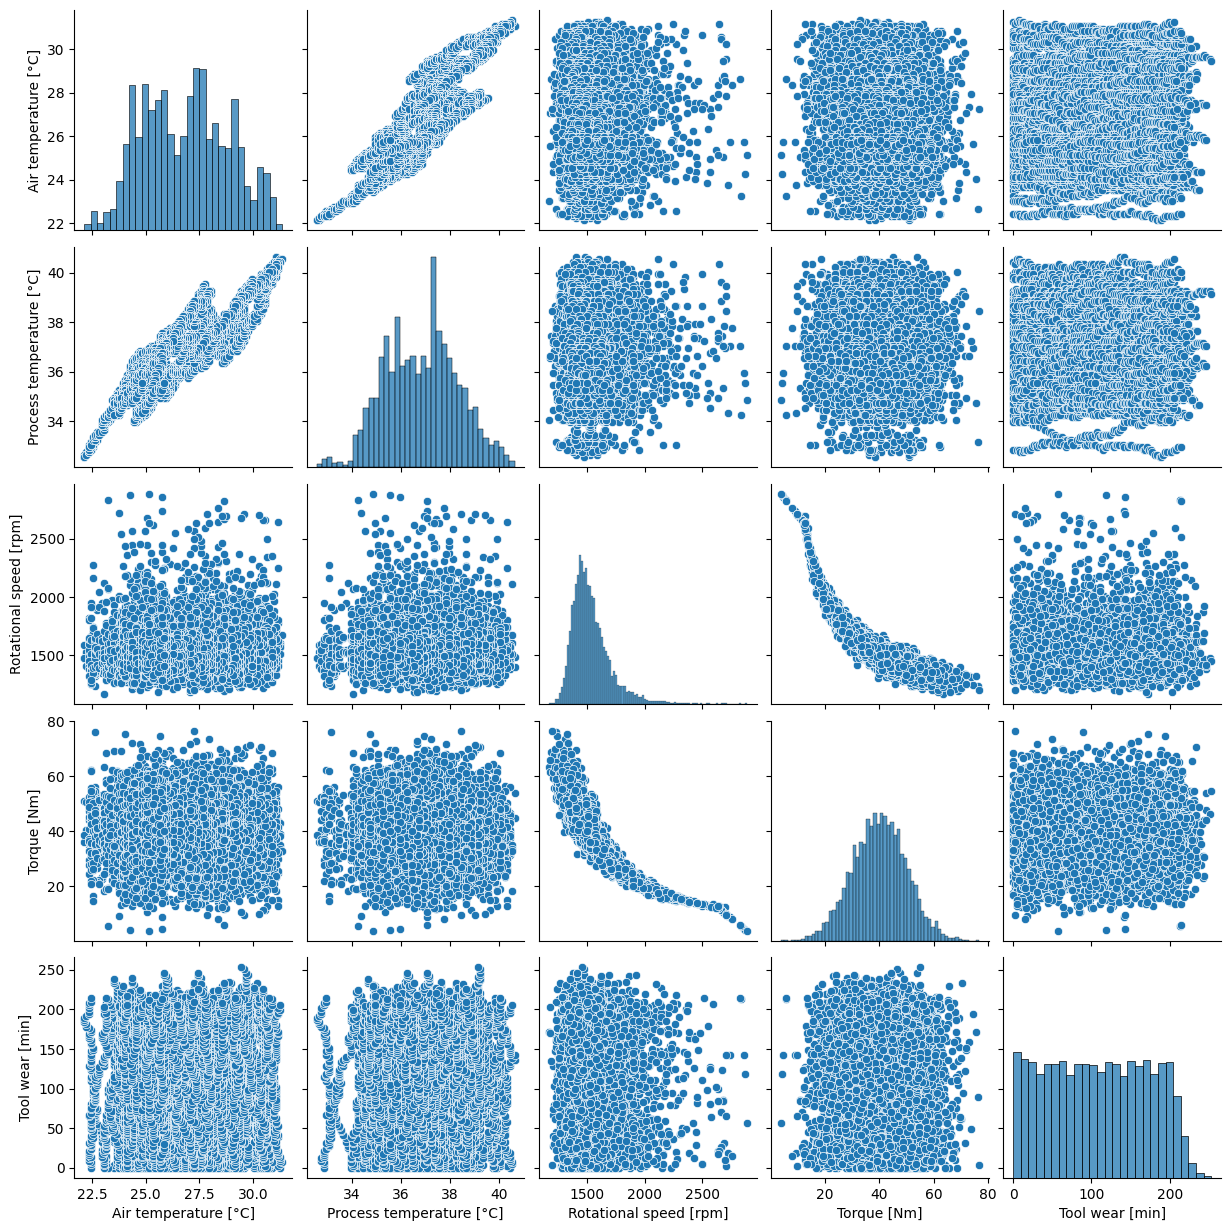

In [81]:
num_cols = df[['Air temperature [°C]', 'Process temperature [°C]', 'Rotational speed [rpm]', 'Torque [Nm]','Tool wear [min]']]
sns.pairplot(num_cols)